In [1]:
from copy import deepcopy

from models import StrideLSTM
from dataset import StrideDataset
from load_data import load_data_from_folder, integrate_ankle_insole
import torch
from torch.utils.data import DataLoader
from torch import nn
from load_data import process_camargo_data, normalize_ankle_angle

In [2]:
train_data_path = "./data/12_11_treadmill_walk_2min/"
cutoff_start = 50
cutoff_end = 180
moticon_offset = 19.6934

if torch.mps.is_available():
    print("Using MPS (Apple) device")
    device = torch.device('mps')
elif torch.cuda.is_available():
    print("Using CUDA (Nvidia) device")
    device = torch.device('cuda')
else:
    print("Using CPU device")
    device = torch.device('cpu')
sequence_len = 100

Using CUDA (Nvidia) device


In [5]:
camargo_ds = process_camargo_data("data/camargo/data/", load_portion=1)

Processing camargo:   0%|          | 0/1101 [00:00<?, ?it/s]

In [ ]:
michael_walk_data, insole_data, _ = load_data_from_folder("data/04_03_walk/", [159], [202], 0, 30.5731)
integrate_ankle_insole(michael_walk_data, insole_data)
michael_walk_data = normalize_ankle_angle(michael_walk_data)
for data in michael_walk_data:
    data.activity = "walk"

michael_downramp_data, insole_data, _ = load_data_from_folder("data/01_16_ramp/", [10,43], [20,55], 0, -0.8789)
integrate_ankle_insole(michael_downramp_data, insole_data)
michael_downramp_data = normalize_ankle_angle(michael_downramp_data)
for data in michael_downramp_data:
    data.activity = "rampdescent"

michael_upramp_data, insole_data, _ = load_data_from_folder("data/01_16_ramp/", [23,62], [34,71], 0, -0.8789)
integrate_ankle_insole(michael_upramp_data, insole_data)
michael_upramp_data = normalize_ankle_angle(michael_upramp_data)
for data in michael_upramp_data:
    data.activity = "rampascent"

michael_downstairs_data, insole_data, _ = load_data_from_folder("data/01_22_downstairs/", 20, 1e9, 0, 0.3675)
integrate_ankle_insole(michael_downstairs_data, insole_data)
michael_downstairs_data = normalize_ankle_angle(michael_downstairs_data)
for data in michael_downstairs_data:
    data.activity = "stairdescent"

michael_upstairs_data, insole_data, _ = load_data_from_folder("data/01_22_upstairs/", 0, 1e9, 0, 2.5461)
integrate_ankle_insole(michael_upstairs_data, insole_data)
michael_upstairs_data = normalize_ankle_angle(michael_upstairs_data)
for data in michael_upstairs_data:
    data.activity = "stairascent"

mohsen_walk_data, insole_data, _ = load_data_from_folder("data/04_14_walk_stair_vending/", 0, 1e9, 0, -60.3619)
integrate_ankle_insole(mohsen_walk_data, insole_data)
mohsen_walk_data = normalize_ankle_angle(mohsen_walk_data)
for data in mohsen_walk_data:
    data.activity = "walk"

mohsen_walk_data2, insole_data, _ = load_data_from_folder("data/04_14_walk_vending_stair/", 0, 1e9, 0, -6.8690)
integrate_ankle_insole(mohsen_walk_data2, insole_data)
mohsen_walk_data2 = normalize_ankle_angle(mohsen_walk_data2)
for data in mohsen_walk_data2:
    data.activity = "walk"

mohsen_walk_data3, insole_data, _ = load_data_from_folder("data/04_14_outdoor_fitz_walk/", 0, 1e9, 0, -7.9118)
integrate_ankle_insole(mohsen_walk_data3, insole_data)
mohsen_walk_data3 = normalize_ankle_angle(mohsen_walk_data3)
for data in mohsen_walk_data3:
    data.activity = "walk"

mohsen_walk_data4, insole_data, _ = load_data_from_folder("data/04_14_walk_fitz_bond/", 0, 1e9, 0, -35.8358)
integrate_ankle_insole(mohsen_walk_data4, insole_data)
mohsen_walk_data4 = normalize_ankle_angle(mohsen_walk_data4)
for data in mohsen_walk_data4:
    data.activity = "walk"

mohsen_walk_data5, insole_data, _ = load_data_from_folder("data/04_14_walk_main_fitz/", 0, 1e9, 0, 3.4172)
integrate_ankle_insole(mohsen_walk_data5, insole_data)
mohsen_walk_data5 = normalize_ankle_angle(mohsen_walk_data5)
for data in mohsen_walk_data5:
    data.activity = "walk"

mohsen_downramp_data1, insole_data, _ = load_data_from_folder("data/04_14_downramp_bond_x2/", 0, 1e9, 0, -22.4661)
integrate_ankle_insole(mohsen_downramp_data1, insole_data)
mohsen_downramp_data1 = normalize_ankle_angle(mohsen_downramp_data1)
for data in mohsen_downramp_data1:
    data.activity = "rampdescent"

mohsen_downramp_data2, insole_data, _ = load_data_from_folder("data/04_14_downramp_lake/", 0, 1e9, 0, -7.1484)
integrate_ankle_insole(mohsen_downramp_data2, insole_data)
mohsen_downramp_data2 = normalize_ankle_angle(mohsen_downramp_data2)
for data in mohsen_downramp_data2:
    data.activity = "rampdescent"

mohsen_downramp_data3, insole_data, _ = load_data_from_folder("data/04_14_downramp_columba_hall/", 0, 1e9, 0, 2.3692)
integrate_ankle_insole(mohsen_downramp_data3, insole_data)
mohsen_downramp_data3 = normalize_ankle_angle(mohsen_downramp_data3)
for data in mohsen_downramp_data3:
    data.activity = "rampdescent"

mohsen_upramp_data1, insole_data, _ = load_data_from_folder("data/04_14_upramp_bond_x2/", 0, 1e9, 0, 1.4235)
integrate_ankle_insole(mohsen_upramp_data1, insole_data)
mohsen_upramp_data1 = normalize_ankle_angle(mohsen_upramp_data1)
for data in mohsen_upramp_data1:
    data.activity = "rampascent"

mohsen_upramp_data2, insole_data, _ = load_data_from_folder("data/04_14_upramp_lake/", 0, 1e9, 0, 2.7880)
integrate_ankle_insole(mohsen_upramp_data2, insole_data)
mohsen_upramp_data2 = normalize_ankle_angle(mohsen_upramp_data2)
for data in mohsen_upramp_data2:
    data.activity = "rampascent"

mohsen_upramp_data3, insole_data, _ = load_data_from_folder("data/04_14_upramp_columba_hall/", 0, 1e9, 0, -7.3961)
integrate_ankle_insole(mohsen_upramp_data3, insole_data)
mohsen_upramp_data3 = normalize_ankle_angle(mohsen_upramp_data3)
for data in mohsen_upramp_data3:
    data.activity = "rampascent"

mohsen_upstairs_data1, insole_data, _ = load_data_from_folder("data/04_14_upstairs_leftfoot_main/", 0, 1e9, 0, -13.6291)
integrate_ankle_insole(mohsen_upstairs_data1, insole_data)
mohsen_upstairs_data1 = normalize_ankle_angle(mohsen_upstairs_data1)
for data in mohsen_upstairs_data1:
    data.activity = "stairascent"

mohsen_upstairs_data2, insole_data, _ = load_data_from_folder("data/04_14_upstairs_rightfoot_main/", 0, 1e9, 0, -11.0419)
integrate_ankle_insole(mohsen_upstairs_data2, insole_data)
mohsen_upstairs_data2 = normalize_ankle_angle(mohsen_upstairs_data2)
for data in mohsen_upstairs_data2:
    data.activity = "stairascent"

mohsen_downstairs_data1, insole_data, _ = load_data_from_folder("data/04_14_downstairs_leftfoot_main/", 0, 1e9, 0, 9.3960)
integrate_ankle_insole(mohsen_downstairs_data1, insole_data)
mohsen_downstairs_data1 = normalize_ankle_angle(mohsen_downstairs_data1)
for data in mohsen_downstairs_data1:
    data.activity = "stairdescent"

mohsen_downstairs_data2, insole_data, _ = load_data_from_folder("data/04_14_downstairs_rightfoot_main/", 0, 1e9, 0, 5.0417)
integrate_ankle_insole(mohsen_downstairs_data2, insole_data)
mohsen_downstairs_data2 = normalize_ankle_angle(mohsen_downstairs_data2)
for data in mohsen_downstairs_data2:
    data.activity = "stairdescent"

michael_data = michael_walk_data + michael_downramp_data + michael_upramp_data + michael_downstairs_data + michael_upstairs_data
mohsen_data = mohsen_walk_data + mohsen_walk_data2 + mohsen_walk_data3 + mohsen_walk_data4 + mohsen_walk_data5 + \
    mohsen_downramp_data1 + mohsen_downramp_data2 + mohsen_downramp_data3 + \
    mohsen_upramp_data1 + mohsen_upramp_data2 + mohsen_upramp_data3 + \
    mohsen_upstairs_data1 + mohsen_upstairs_data2 + \
    mohsen_downstairs_data1 + mohsen_downstairs_data2

In [6]:
pretrain_ds = [StrideDataset(normalize_ankle_angle(data), sequence_length=sequence_len) for data in camargo_ds]
pretrain_pos_weight = sum([sum(ds.labels == 0) for ds in pretrain_ds]) / sum([sum(ds.labels == 1) for ds in pretrain_ds])
batch_size = 1024
# combine all datasets
pretrain_ds = torch.utils.data.ConcatDataset(pretrain_ds)
num_samples = len(pretrain_ds)
num_train_samples = int(0.8 * num_samples)
pretrain_train, pretrain_val = torch.utils.data.random_split(pretrain_ds, [num_train_samples, num_samples - num_train_samples])
pretrain_loader = DataLoader(pretrain_train, batch_size=batch_size)
pretrain_val_loader = DataLoader(pretrain_val, batch_size=batch_size)
print("Pretraining train size:", len(pretrain_train))
print("Pretraining val size:", len(pretrain_val))

Pretraining train size: 639827
Pretraining val size: 159957


In [23]:
# ankle_data, insole_data, _ = load_data_from_folder(train_data_path, cutoff_start, cutoff_end, 0, moticon_offset)
# ankle_data, insole_data, _ = load_data_from_folder("./data/01_16_up_down_stairs/", 16, 140, 0, 14.4)
# walk outside

dataset = StrideDataset(michael_walk_data+michael_upramp_data+michael_upstairs_data,sequence_length=sequence_len)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
print(f'Train size: {train_size}, Validation size: {val_size}')
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

print("Initializing Model")
input_size = 7  # 3 (accel) * 2 + 1 (ankle angle)

val_loader = DataLoader(val_dataset, batch_size=32)
train_loader = DataLoader(train_dataset,batch_size=32)

Train size: 8329, Validation size: 2083
Initializing Model


In [24]:
def vote_activity(imu_data):
    activities = [data.activity for data in imu_data]
    activity_counts = {activity: activities.count(activity) for activity in set(activities)}
    # sort by count
    sorted_activities = sorted(activity_counts.items(), key=lambda x: x[1], reverse=True)
    # return the most common activity that is not idle
    for activity, count in sorted_activities:
        if activity != "idle" and '-' not in activity and activity != "stand":
            return activity

activity: walk


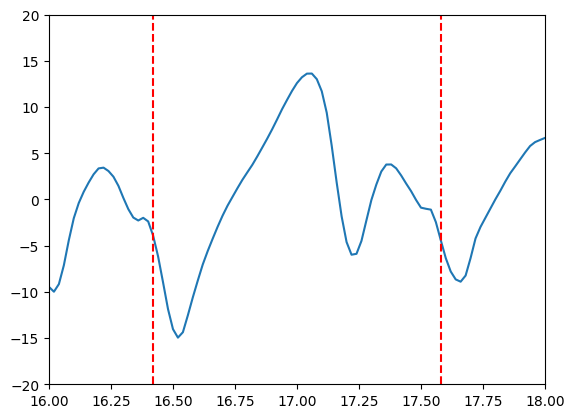

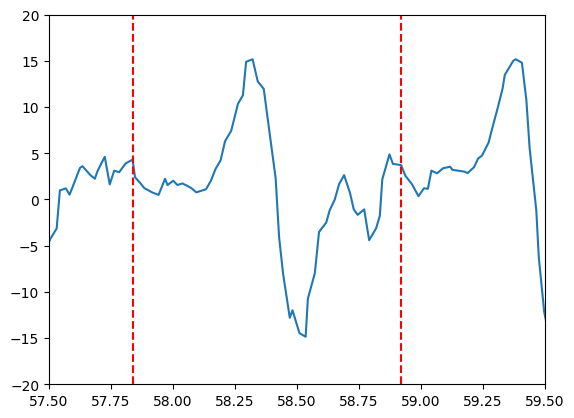

In [25]:
# visualize pretrain data ankle angle vs force
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import random

def visualize_data(ds, xlim=None, mult=1):
    # get all samples' ankle angles and forces
    integrate_ankle_insole(ds)
    ankle_angles = [mult*data.get_ankle_angle() for data in ds]
    imu_0_x = [data.accel1[2]*mult for data in ds]
    times = [data.timestep for data in ds]
    # smooth the ankle angles
    ankle_angles = np.array(ankle_angles)
    times = np.array(times)
    window_size = 10
    polyorder = 3
    ankle_angles = savgol_filter(ankle_angles, window_size, polyorder)
    plt.plot(times, ankle_angles)
    plt.ylim([-20, 20])
    # ax2 = plt.twinx()
    # ax2.plot(times, imu_0_x, color='r')
    # ax2.set_ylabel("Force (N)")
    # ax2.set_ylim([-30, 20])
    # plot heel strikes
    heel_strikes = [data.timestep for data in ds if data.heel_striking]
    for time in heel_strikes:
        plt.axvline(x=time, color='r', linestyle='--')
    # plot ankle angles
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()
selector = 20
print(f"activity: {vote_activity(camargo_ds[selector])}")
visualize_data(camargo_ds[selector],xlim=[16, 18], mult=1)
visualize_data(ankle_data, xlim=[57.5, 59.5])

In [10]:
model = StrideLSTM(input_size=input_size, hidden_size=128, num_layers=2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_accs = []
val_accs = []
model.to(device)

StrideLSTM(
  (lstm): LSTM(7, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (lstm_dropout): Dropout(p=0.5, inplace=False)
  (batch_norm_lstm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (attention): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Softmax(dim=1)
  )
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc_dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [12]:
# load model instead if you want
# model.load_state_dict(torch.load('stride_segmentation_model.pth'))

In [13]:
# Define the loss function with class weights
print(f"Pretraining pos weight: {pretrain_pos_weight}")
class_weights = torch.tensor([1.0, pretrain_pos_weight], device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# pretraining loop
num_epochs = 20
from tqdm.auto import tqdm
for epoch in tqdm(range(num_epochs)):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in tqdm(pretrain_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= train_total
    train_acc = train_correct / train_total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_total_true_strikes = 0
    val_total_predicted_strikes = 0

    with torch.no_grad():
        for inputs, labels in pretrain_val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_total_true_strikes += (labels == 1).sum().item()
            val_total_predicted_strikes += (predicted == 1).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}] | '
          f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, total true strikes: {val_total_true_strikes}, total predicted strikes: {val_total_predicted_strikes}')

Pretraining pos weight: 0.6030048131942749


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1/20] | Train Loss: 0.1924, Acc: 0.9167 | Val Loss: 0.1179, Acc: 0.9472, total true strikes: 99752, total predicted strikes: 96603


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2/20] | Train Loss: 0.1044, Acc: 0.9559 | Val Loss: 0.1017, Acc: 0.9517, total true strikes: 99752, total predicted strikes: 93782


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3/20] | Train Loss: 0.0850, Acc: 0.9637 | Val Loss: 0.0724, Acc: 0.9692, total true strikes: 99752, total predicted strikes: 98498


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4/20] | Train Loss: 0.0718, Acc: 0.9694 | Val Loss: 0.0676, Acc: 0.9723, total true strikes: 99752, total predicted strikes: 98325


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5/20] | Train Loss: 0.0616, Acc: 0.9740 | Val Loss: 0.0520, Acc: 0.9784, total true strikes: 99752, total predicted strikes: 98748


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6/20] | Train Loss: 0.0530, Acc: 0.9777 | Val Loss: 0.0450, Acc: 0.9816, total true strikes: 99752, total predicted strikes: 99043


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7/20] | Train Loss: 0.0498, Acc: 0.9791 | Val Loss: 0.0458, Acc: 0.9810, total true strikes: 99752, total predicted strikes: 98696


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8/20] | Train Loss: 0.0459, Acc: 0.9807 | Val Loss: 0.0388, Acc: 0.9834, total true strikes: 99752, total predicted strikes: 98652


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9/20] | Train Loss: 0.0424, Acc: 0.9822 | Val Loss: 0.0413, Acc: 0.9837, total true strikes: 99752, total predicted strikes: 99304


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10/20] | Train Loss: 0.0399, Acc: 0.9832 | Val Loss: 0.0476, Acc: 0.9800, total true strikes: 99752, total predicted strikes: 98021


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11/20] | Train Loss: 0.0388, Acc: 0.9838 | Val Loss: 0.0375, Acc: 0.9849, total true strikes: 99752, total predicted strikes: 99273


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12/20] | Train Loss: 0.0354, Acc: 0.9852 | Val Loss: 0.0338, Acc: 0.9858, total true strikes: 99752, total predicted strikes: 99006


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13/20] | Train Loss: 0.0368, Acc: 0.9845 | Val Loss: 0.0436, Acc: 0.9805, total true strikes: 99752, total predicted strikes: 98122


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14/20] | Train Loss: 0.0343, Acc: 0.9855 | Val Loss: 0.0348, Acc: 0.9854, total true strikes: 99752, total predicted strikes: 98909


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [15/20] | Train Loss: 0.0326, Acc: 0.9862 | Val Loss: 0.0421, Acc: 0.9825, total true strikes: 99752, total predicted strikes: 98923


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [16/20] | Train Loss: 0.0309, Acc: 0.9869 | Val Loss: 0.0355, Acc: 0.9855, total true strikes: 99752, total predicted strikes: 99217


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [17/20] | Train Loss: 0.0304, Acc: 0.9870 | Val Loss: 0.0354, Acc: 0.9863, total true strikes: 99752, total predicted strikes: 99442


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [18/20] | Train Loss: 0.0289, Acc: 0.9877 | Val Loss: 0.0334, Acc: 0.9868, total true strikes: 99752, total predicted strikes: 99477


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [19/20] | Train Loss: 0.0286, Acc: 0.9879 | Val Loss: 0.0322, Acc: 0.9875, total true strikes: 99752, total predicted strikes: 99710


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [20/20] | Train Loss: 0.0287, Acc: 0.9879 | Val Loss: 0.0342, Acc: 0.9859, total true strikes: 99752, total predicted strikes: 99222


In [26]:
# Define the loss function with class weights
pos_weight_value = dataset.pos_weight.item()
print(f"Pos weight: {pos_weight_value}")
class_weights = torch.tensor([1.0, pos_weight_value], device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Training loop
num_epochs = 15
from tqdm.auto import tqdm
for epoch in tqdm(range(num_epochs)):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= train_total
    train_acc = train_correct / train_total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_total_true_strikes = 0
    val_total_predicted_strikes = 0

    with (torch.no_grad()):
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_total_true_strikes += (labels == 1).sum().item()
            val_total_predicted_strikes += (predicted == 1).sum().item()


    val_loss /= val_total
    val_acc = val_correct / val_total
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}] | '
          f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, total true strikes: {val_total_true_strikes}, total predicted strikes: {val_total_predicted_strikes}')

Pos weight: 0.5120534300804138


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/100] | Train Loss: 0.1567, Acc: 0.9397 | Val Loss: 0.0873, Acc: 0.9717, total true strikes: 1355, total predicted strikes: 1334
Epoch [2/100] | Train Loss: 0.0977, Acc: 0.9618 | Val Loss: 0.0750, Acc: 0.9698, total true strikes: 1355, total predicted strikes: 1328
Epoch [3/100] | Train Loss: 0.0754, Acc: 0.9679 | Val Loss: 0.0725, Acc: 0.9765, total true strikes: 1355, total predicted strikes: 1354
Epoch [4/100] | Train Loss: 0.0675, Acc: 0.9721 | Val Loss: 0.0741, Acc: 0.9784, total true strikes: 1355, total predicted strikes: 1360
Epoch [5/100] | Train Loss: 0.0679, Acc: 0.9727 | Val Loss: 0.0708, Acc: 0.9736, total true strikes: 1355, total predicted strikes: 1342
Epoch [6/100] | Train Loss: 0.0682, Acc: 0.9700 | Val Loss: 0.0622, Acc: 0.9731, total true strikes: 1355, total predicted strikes: 1347
Epoch [7/100] | Train Loss: 0.0609, Acc: 0.9771 | Val Loss: 0.0588, Acc: 0.9741, total true strikes: 1355, total predicted strikes: 1335
Epoch [8/100] | Train Loss: 0.0574, Acc: 

In [16]:
# Save the model
torch.save(model.state_dict(), 'stride_segmentation.pth')

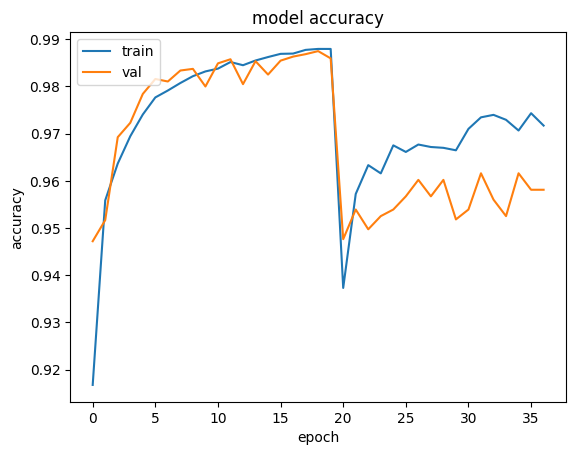

In [17]:
# plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(train_accs)
plt.plot(val_accs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
import numpy as np
from tqdm import tqdm

plotting_data = normalize_ankle_angle(michael_downstairs_data)
# infer the ankle angles on the plotting data
def evaluate_model(model, ankle_data, device, sequence_length=100):
    # Create full dataset without splits
    full_dataset = StrideDataset(ankle_data, sequence_length=sequence_length)
    eval_loader = DataLoader(full_dataset, batch_size=128, shuffle=False)

    # Initialize arrays to store predictions and ground truth
    total_timesteps = len(ankle_data)
    all_predictions = np.full(total_timesteps, -1, dtype=np.int64)  # -1 = no prediction
    all_labels = np.full(total_timesteps, -1, dtype=np.int64)

    model.eval()
    current_position = sequence_length//2

    with torch.no_grad():
        for batch_features, batch_labels in tqdm(eval_loader):
            batch_features = batch_features.to(device)

            # Make predictions
            outputs = model(batch_features)
            batch_preds = torch.argmax(outputs, dim=1).cpu().numpy()

            # Store predictions and labels
            batch_size = len(batch_preds)
            end_position = current_position + batch_size
            all_predictions[current_position:end_position] = batch_preds
            all_labels[current_position:end_position] = batch_labels.numpy()

            current_position = end_position

    return all_predictions, all_labels

# Evaluate the model
predictions, labels = evaluate_model(model, plotting_data, sequence_length=sequence_len, device=device)
print(f"True Strikes: {np.sum(labels == 1)}")
print(f"Predicted Strikes: {np.sum(predictions == 1)}")

gt_data = deepcopy(plotting_data)
# remove force data
for data in plotting_data:
    data.force = 0
for data, prediction in zip(plotting_data, predictions):
    data.force = 300 if prediction == 1 else 0

integrate_ankle_insole(plotting_data)

heel_striking_times = [data.timestep for data in plotting_data if data.heel_striking]
gt_heel_striking_times = [data.timestep for data in gt_data if data.heel_striking]

# for each gt heel striking time, find the closest predicted heel striking time
predicted_heel_striking_times = []
for gt_time in gt_heel_striking_times:
    closest_time = min(heel_striking_times, key=lambda x: abs(x - gt_time))
    predicted_heel_striking_times.append(closest_time)
print(f"Average Error: {np.mean(np.abs(np.array(predicted_heel_striking_times) - np.array(gt_heel_striking_times)))}s")
print(f"# of Predicted Heel Strikes: {len(predicted_heel_striking_times)}, # of GT Heel Strikes: {len(gt_heel_striking_times)}")
print(f"Predicted Heel Strikes: {heel_striking_times}")
print(f"GT Heel Strikes: {gt_heel_striking_times}")
print(np.abs(np.array(predicted_heel_striking_times) - np.array(gt_heel_striking_times)))

100%|██████████| 52/52 [00:00<00:00, 109.51it/s]


True Strikes: 4946
Predicted Strikes: 4563
Average Error: 0.3165090909090905s
# of Predicted Heel Strikes: 55, # of GT Heel Strikes: 55
Predicted Heel Strikes: [21.004, 26.286, 27.502, 27.882, 28.907, 29.224, 30.807, 32.656, 32.718, 40.048, 41.524, 42.197, 46.882, 48.209, 49.458, 50.817, 52.221, 52.447, 54.67, 62.78, 63.025, 64.24, 64.616, 65.019, 71.303, 72.614, 73.79, 75.633, 77.158, 77.472, 77.778, 87.317, 88.843, 92.021, 93.312, 94.95, 96.227, 97.691, 99.408, 99.675, 106.136, 108.244, 109.269, 113.366, 114.656, 115.932, 117.226, 118.61, 120.738, 130.395, 131.897, 132.364, 138.028, 139.385, 139.519, 140.626, 140.861, 141.948, 143.53, 144.786, 146.042, 146.403, 148.498]
GT Heel Strikes: [26.286, 27.221, 27.687, 29.061, 30.388, 31.883, 38.576, 39.989, 41.231, 46.329, 46.427, 46.937, 48.277, 49.588, 50.891, 52.283, 53.816, 61.431, 62.722, 64.115, 71.44, 72.686, 73.948, 75.303, 76.76, 85.569, 86.976, 88.374, 91.612, 92.104, 93.365, 94.691, 96.096, 97.494, 99.048, 106.45, 107.917, 109.39

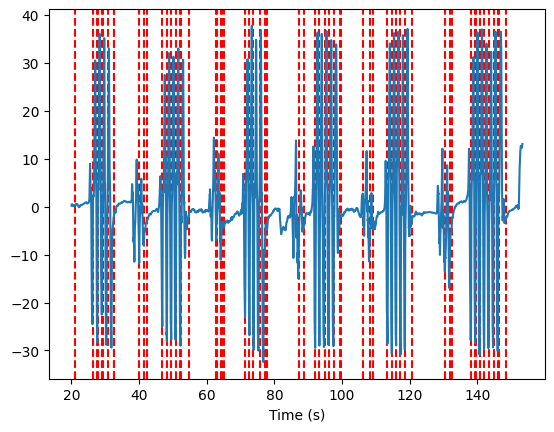

In [30]:
# plot ankle angle over time
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
ankle_angles = [data.get_ankle_angle() for data in plotting_data]
times = [data.timestep for data in plotting_data]
# smooth the ankle angles
ankle_angles = np.array(ankle_angles)
times = np.array(times)
window_size = 10
polyorder = 3
ankle_angles = savgol_filter(ankle_angles, window_size, polyorder)

# vertical line at heel lifting
heel_striking_times = [data.timestep for data in plotting_data if data.heel_striking]
for time in heel_striking_times:
    plt.axvline(x=time, color='r', linestyle='--')

# plot fsr voltage
# ax2 = plt.twinx()
# fsr_voltage = [data.fsr_voltage for data in plotting_data]
# ax2.plot(times, fsr_voltage, color='g')
# ax2.set_ylabel("FSR Voltage (V)")

plt.plot(times, ankle_angles)
plt.xlabel('Time (s)')
# plt.ylabel('Ankle Angle (degrees)')
# plt.xlim([60, 80])
plt.show()

In [31]:
class Segment:
    def __init__(self):
        self.start_time = 0
        self.end_time = 0
        self.data = []

    def add_data(self, data):
        self.data.append(data)
        if self.start_time == 0:
            self.start_time = data.timestep
        self.end_time = data.timestep

    def interval(self):
        return self.end_time - self.start_time

In [32]:
segments = []
current_segment = Segment()
for data in plotting_data:
    if data.heel_striking:
        if current_segment.data:
            segments.append(current_segment)
        current_segment = Segment()
    current_segment.add_data(data)

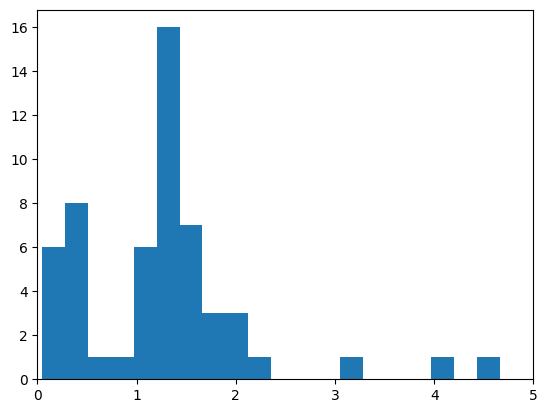

In [33]:
# plot histogram of segment intervals
import matplotlib.pyplot as plt
import numpy as np

segment_intervals = [segment.interval() for segment in segments if segment.interval()<5]

plt.hist(segment_intervals, bins=20)
plt.xlim([0, 5])
# plot max ankle angle difference for each segment
ankle_angles = [[x.get_ankle_angle() for x in segment.data] for segment in segments]
ankle_angle_diffs = [max(angles) - min(angles) for angles in ankle_angles]

Filtered 20 segments


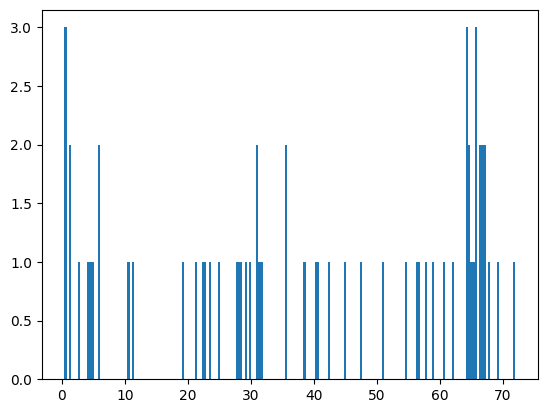

In [34]:
plt.hist(ankle_angle_diffs, bins=200)
# overlay each segment on the ankle angle plot
# time_filter = [1.4, 1.6]
time_filter = [1, 1.5]
filtered_segments = [segment for segment in segments if
                     segment.interval() > time_filter[0] and segment.interval() < time_filter[1]]
# then filter out segments with small ankle angle differences (<20 degrees)
filtered_segments = [segment for segment in filtered_segments if
                     max([data.get_ankle_angle() for data in segment.data]) - min(
                         [data.get_ankle_angle() for data in segment.data]) > 30]
# filtered_segments = segments
print(f"Filtered {len(filtered_segments)} segments")

In [35]:

# normalize the time axis to % stride
for segment in filtered_segments:
    segment_interval = segment.interval()
    for data in segment.data:
        data.perc_stride = (data.timestep - segment.start_time) / segment_interval * 100

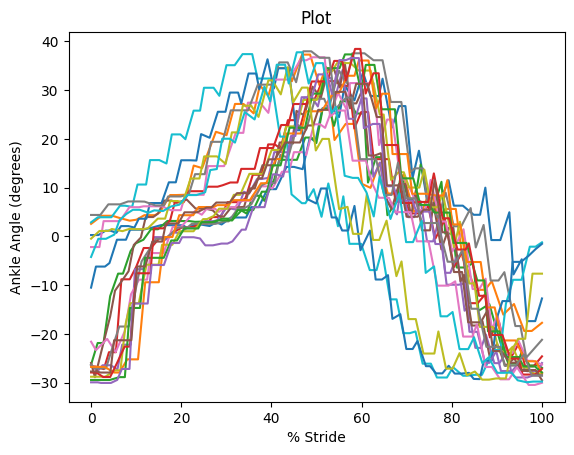

In [36]:

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

ankle_angles = [[x.get_ankle_angle() for x in segment.data] for segment in filtered_segments]

# overlay each segment on the ankle angle plot
fig, ax1 = plt.subplots()
for angles in ankle_angles[:]:
    perc_stride = [data.perc_stride for data in filtered_segments[ankle_angles.index(angles)].data]
    ax1.plot(perc_stride, angles)
ax1.set_ylabel("Ankle Angle (degrees)")
plt.xlabel("% Stride")
plt.title("Plot")
plt.show()

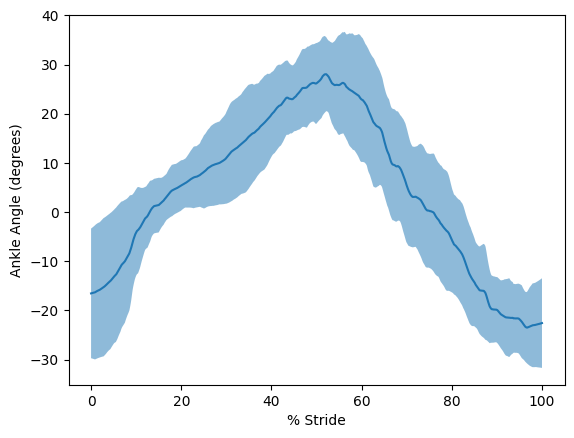

In [37]:
# plot mean and std ankle angle as a whole for all segments
# linear interpolate for 1000 datapoints per segment
import numpy as np
from scipy.interpolate import interp1d

interp_angles = []
for segment in filtered_segments:
    interp_angles.append(
        interp1d([data.perc_stride for data in segment.data], [data.get_ankle_angle() for data in segment.data],
                 kind='linear'))
stride = np.linspace(0, 100, 1000)
angles = [angle(stride) for angle in interp_angles]
angles = np.array(angles)
mean = np.mean(angles, axis=0)
std = np.std(angles, axis=0)
plt.plot(stride, mean)
plt.fill_between(stride, mean - std, mean + std, alpha=0.5)
plt.ylabel("Ankle Angle (degrees)")
plt.xlabel("% Stride")
plt.show()
# shift data by 50% stride
# shifted_angles = []
# plt.figure(figsize=(6, 5))
# shift_by = 60
# for angle in angles:
#     # shifted_angles.append(np.roll(angle, 800))
#     shifted_angles.append(np.roll(angle, int(shift_by / 100 * 1000)) - 50)
# shifted_angles = np.array(shifted_angles)
# mean = np.mean(shifted_angles, axis=0)
# std = np.std(shifted_angles, axis=0)
# plt.plot(stride, mean)
# plt.fill_between(stride, mean - std, mean + std, alpha=0.5)
# plt.axhline(y=0, color='r', linestyle='-')
# # vertical line at shift_by
# # plt.axvline(x=shift_by, color='r', linestyle='--')
# # plot -40 to 40
# plt.ylim(-35, 35)
#
# plt.ylabel("Ankle Angle (degrees)")
# plt.xlabel("% Stride")
# plt.title("Walk")
# plt.show()